In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score
from math import sqrt

In [2]:
df = pd.read_csv('AirPassengers.csv',parse_dates=True,index_col=0,header=0)
df = pd.DataFrame(df.groupby(df.index.strftime('%Y-%m')).sum()['#Passengers'])
df.columns=['Value']
     

In [3]:
df

,Value
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121
...,...
1960-08,606
1960-09,508
1960-10,461


In [4]:
df.head()

,Value
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [5]:
df.tail()

,Value
Month,
1960-08,606
1960-09,508
1960-10,461
1960-11,390
1960-12,432


In [6]:
df.describe()

,Value
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 1949-01 to 1960-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Value   144 non-null    int64
dtypes: int64(1)
memory usage: 2.2+ KB


In [8]:
df.isnull().sum()

Value    0
dtype: int64

In [9]:
#VISUALIZING THE DATA

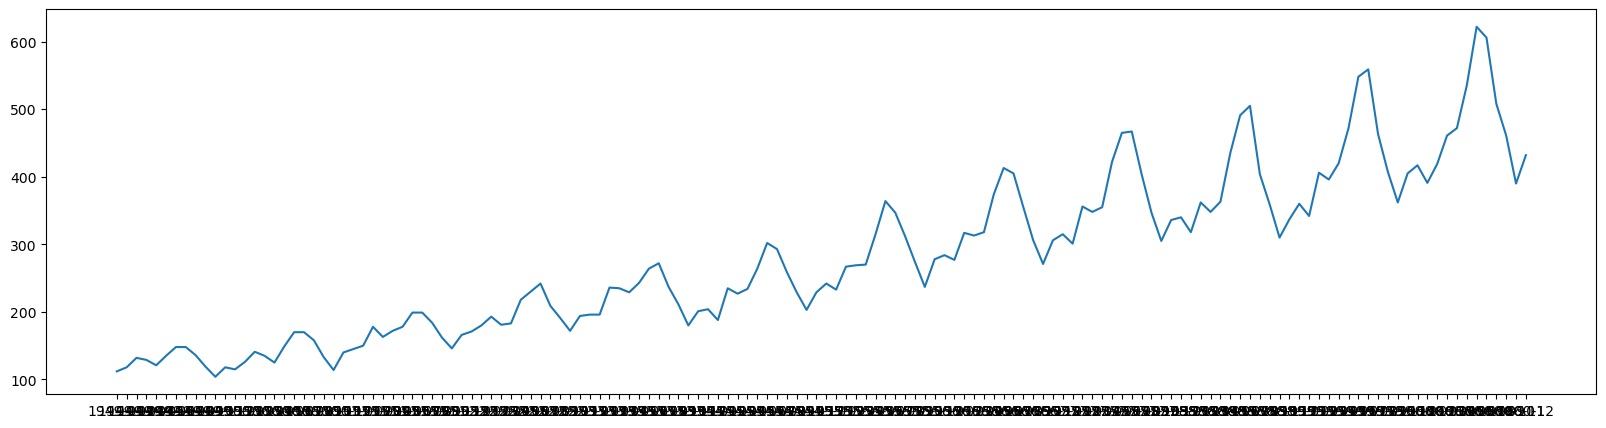

In [10]:
plt.figure(figsize=(20,5))
plt.plot(df)

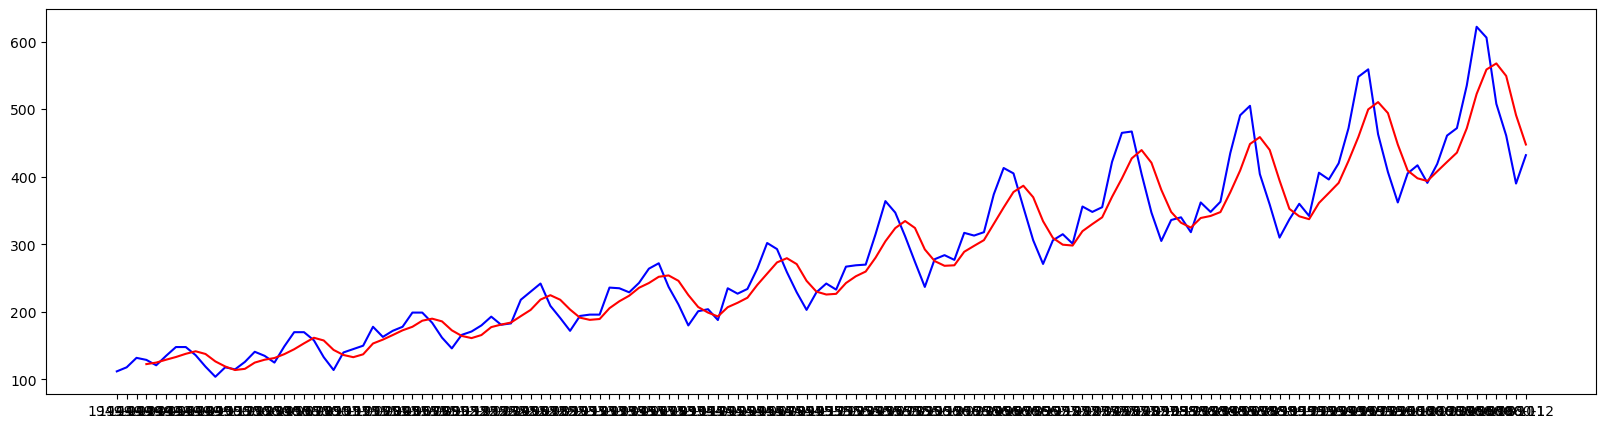

In [11]:
plt.figure(figsize=(20,5))
four_months_moving_average=df.rolling(window=4).mean()
plt.plot(df,color='blue')
plt.plot(four_months_moving_average,color='red')
plt.show()

<Axes: xlabel='Value', ylabel='Density'>

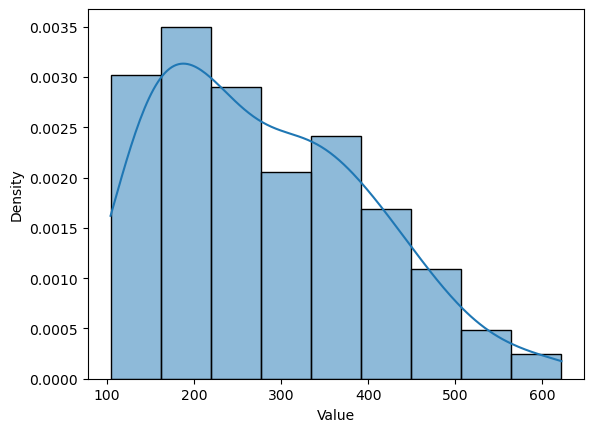

In [12]:
sns.histplot(df['Value'],kde=True,stat='density')

<Figure size 640x480 with 0 Axes>

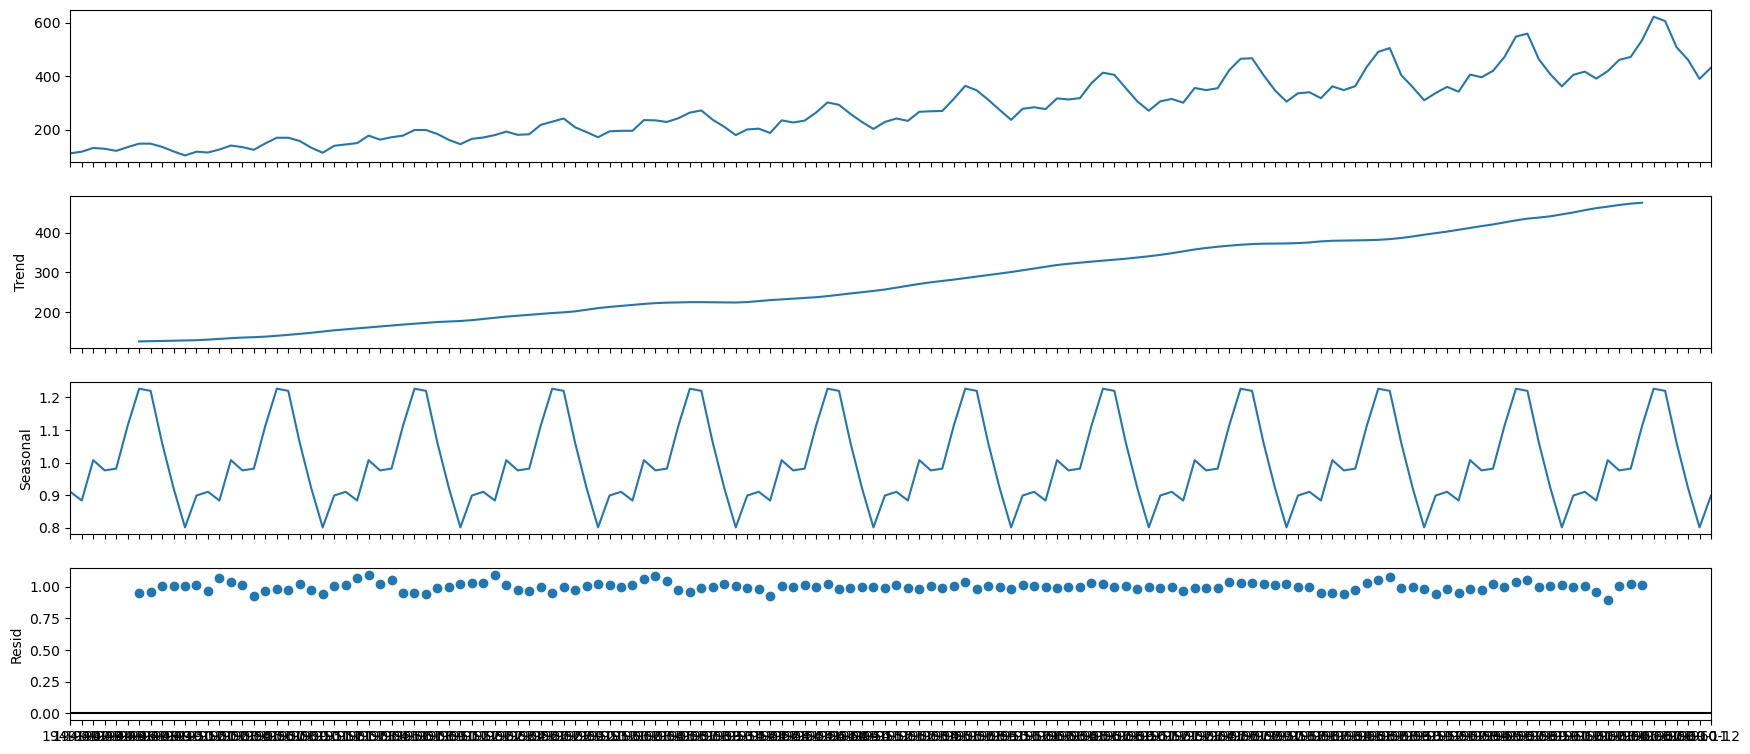

In [13]:
seasonal=seasonal_decompose(df,model='multiplicative',period=12)
fig=plt.figure()
fig=seasonal.plot()
fig.set_size_inches(20,8)

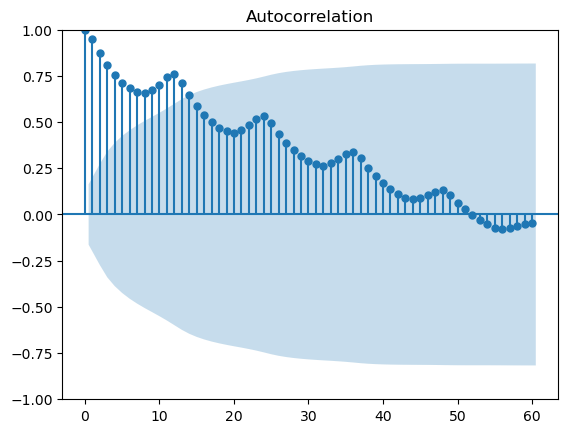

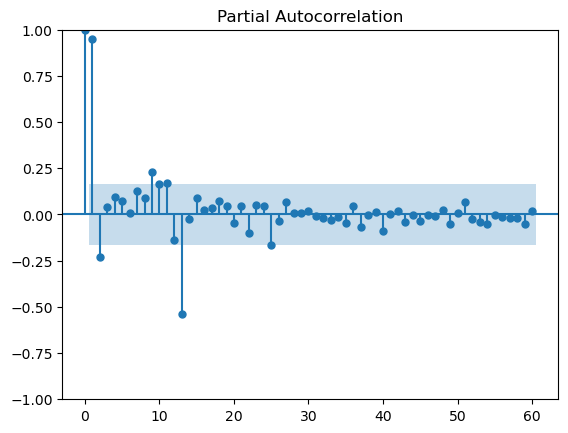

In [14]:
acf=plot_acf(df['Value'],lags=60)
pacf=plot_pacf(df['Value'],lags=60)

In [15]:
# ADF TEST(augumented dickey fuller test)

In [16]:
from statsmodels.tsa.stattools import adfuller

def adf_check(time_series):
    
    #Pass in a time series, returns ADF report

    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")
     

In [17]:
adf_check(df)

Augmented Dickey-Fuller Test:
ADF Test Statistic : 0.8153688792060597
p-value : 0.9918802434376411
Number of Lags Used : 13
Number of Observations Used : 130
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 



In [18]:
#BUILDING ARIMA MODEL

#MATHEMATICAL EQUATION
#y't = C + ϕ1y't–1 +⋅⋅⋅ ϕp y't–p + θ1ϵ't–1 +⋅⋅⋅+ θqϵ't–q + ϵt
#1.MAKING THE DATA STATIONARY BY DIFFERENCING
#2.FITTING THE AUTO REGRESSIVE MODEL
#3.FITTING THE MOVING AVERAGE MODEL ON RESIDUALS

In [19]:
df1= pd.DataFrame(np.log(df.Value).diff().diff(1))
adf_check(df1.Value.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -8.196629132182247
p-value : 7.419304549375835e-13
Number of Lags Used : 13
Number of Observations Used : 128
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='Month'>

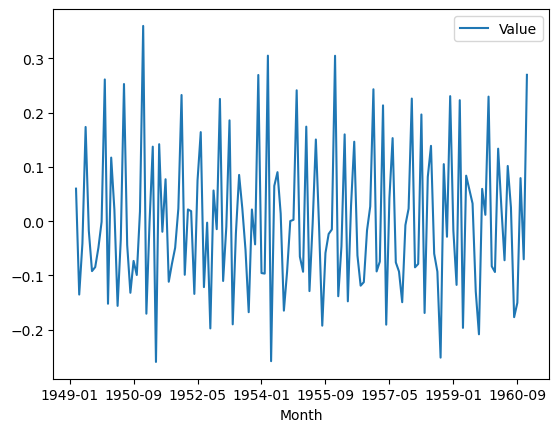

In [20]:
df1.plot()

In [21]:
#AR MODEL

In [22]:
def AR(p,df):
  df_temp = df

  #Generating the lagged p terms
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['Value'].shift(i)

  train_size = (int)(0.8 * df_temp.shape[0])

  #Breaking data set into test and training
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # df_train_2[['Value','Predicted_Values']].plot()

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  # df_test[['Value','Predicted_Values']].plot()

  RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_2,df_test,theta,intercept,RMSE]
     


In [23]:


for i in range(1,21):
  [df_train,df_test,theta,intercept,RMSE] = AR(i,pd.DataFrame(df1.Value))
  

The RMSE is : 0.1352048432378102 , Value of p :  1
The RMSE is : 0.13787988618978836 , Value of p :  2
The RMSE is : 0.13703420032397556 , Value of p :  3
The RMSE is : 0.12677116591284637 , Value of p :  4
The RMSE is : 0.12689606632287592 , Value of p :  5
The RMSE is : 0.12622952914228447 , Value of p :  6
The RMSE is : 0.12631600495563983 , Value of p :  7
The RMSE is : 0.11479219266526174 , Value of p :  8
The RMSE is : 0.11446278715194003 , Value of p :  9
The RMSE is : 0.09676709085638452 , Value of p :  10
The RMSE is : 0.043345451456024864 , Value of p :  11
The RMSE is : 0.03842908529897821 , Value of p :  12
The RMSE is : 0.038489242364914474 , Value of p :  13
The RMSE is : 0.04043771095348556 , Value of p :  14
The RMSE is : 0.040457417658025956 , Value of p :  15
The RMSE is : 0.0397875464538259 , Value of p :  16
The RMSE is : 0.039339839827414 , Value of p :  17
The RMSE is : 0.0388299519926077 , Value of p :  18
The RMSE is : 0.038437243485497534 , Value of p :  19
The

C:\Users\user\AppData\Local\Temp\ipykernel_8756\2532613571.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_8756\2532613571.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_8756\2532613571.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [24]:
[df_train,df_test,theta,intercept,RMSE] = AR(12,pd.DataFrame(df1.Value))

The RMSE is : 0.03842908529897821 , Value of p :  12


C:\Users\user\AppData\Local\Temp\ipykernel_8756\2532613571.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


<Axes: xlabel='Month'>

<Figure size 2000x500 with 0 Axes>

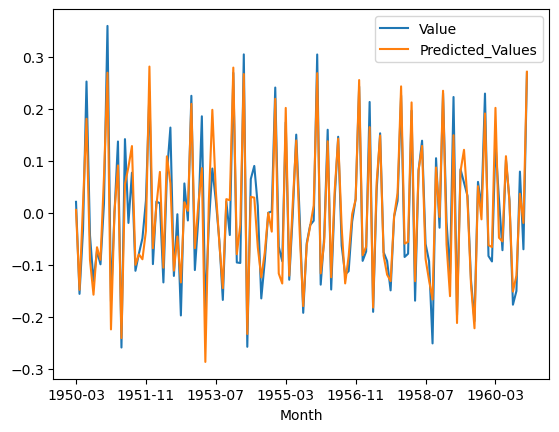

In [25]:
df2 = pd.concat([df_train,df_test])
plt.figure(figsize=(20,5))
df2[['Value','Predicted_Values']].plot()
     

In [26]:
res = pd.DataFrame()
res['Residuals'] = df2.Value - df2.Predicted_Values
     

In [27]:
res

,Residuals
Month,
1950-03,0.015581
1950-04,-0.007798
1950-05,-0.051227
1950-06,0.071661
1950-07,0.047126
...,...
1960-08,-0.025259
1960-09,-0.029820
1960-10,0.042594


<Axes: ylabel='Density'>

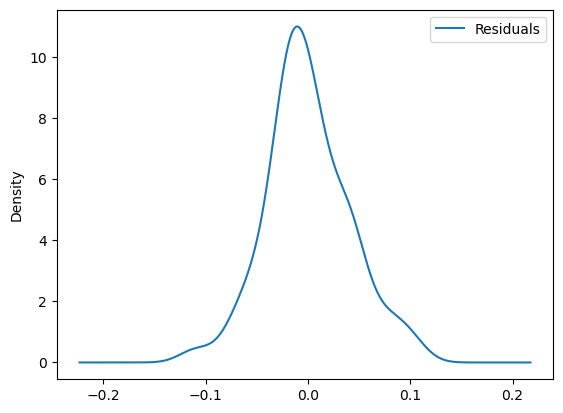

In [28]:
res.plot(kind='kde')

In [29]:
#MA MODEL

In [30]:
def MA(q,res):

  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  train_size = (int)(0.8 * res.shape[0])

  res_train = pd.DataFrame(res[0:train_size])
  res_test = pd.DataFrame(res[train_size:res.shape[0]])

  res_train_2 = res_train.dropna()
  X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
  y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # res_train_2[['Residuals','Predicted_Values']].plot()

  X_test = res_test.iloc[:,1:].values.reshape(-1,q)
  res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  res_test[['Residuals','Predicted_Values']].plot()

  from sklearn.metrics import mean_squared_error
  RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of q : ",q)
  return [res_train_2,res_test,theta,intercept,RMSE]



C:\Users\user\AppData\Local\Temp\ipykernel_8756\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_8756\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_8756\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

The RMSE is : 0.03619862346118975 , Value of q :  1
The RMSE is : 0.036525247401844506 , Value of q :  2
The RMSE is : 0.03593799043026054 , Value of q :  3
The RMSE is : 0.03586352428971274 , Value of q :  4
The RMSE is : 0.035997406849013 , Value of q :  5
The RMSE is : 0.03605342585587492 , Value of q :  6
The RMSE is : 0.0361187425762435 , Value of q :  7
The RMSE is : 0.03561016244652564 , Value of q :  8
The RMSE is : 0.033553354507647404 , Value of q :  9
The RMSE is : 0.03372000041156968 , Value of q :  10
The RMSE is : 0.033193180961945665 , Value of q :  11


C:\Users\user\AppData\Local\Temp\ipykernel_8756\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_8756\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_8756\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

The RMSE is : 0.03183724748707899 , Value of q :  12
The RMSE is : 0.032580195970897056 , Value of q :  13
The RMSE is : 0.03251002526185029 , Value of q :  14
The RMSE is : 0.03260047600832531 , Value of q :  15
The RMSE is : 0.03176519534006695 , Value of q :  16
The RMSE is : 0.032459098394985064 , Value of q :  17
The RMSE is : 0.032495979741721165 , Value of q :  18


C:\Users\user\AppData\Local\Temp\ipykernel_8756\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_8756\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_8756\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

The RMSE is : 0.032523314563609566 , Value of q :  19
The RMSE is : 0.03269107368787665 , Value of q :  20


C:\Users\user\AppData\Local\Temp\ipykernel_8756\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


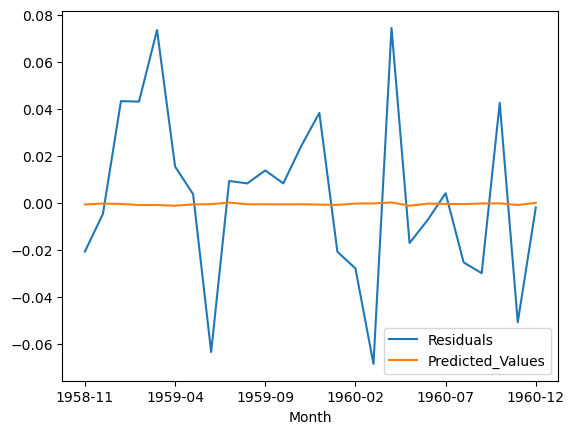

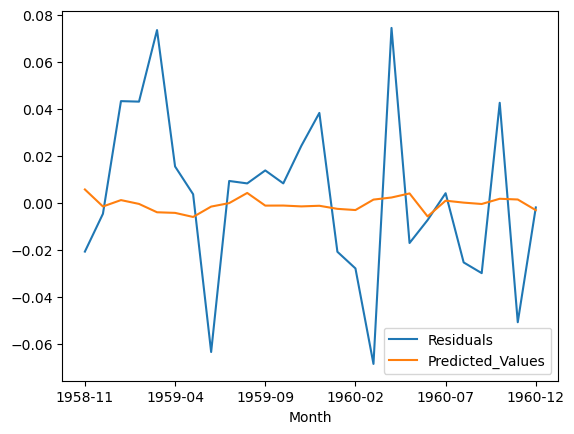

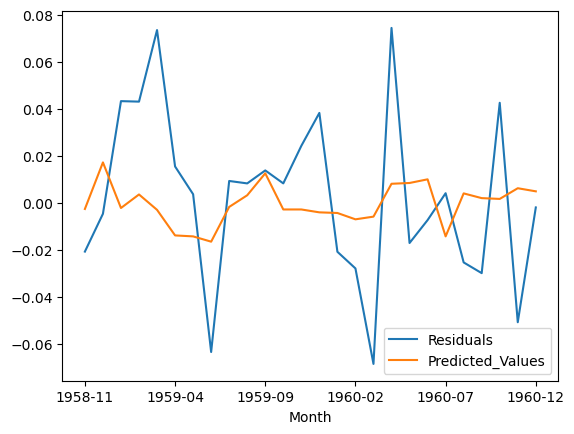

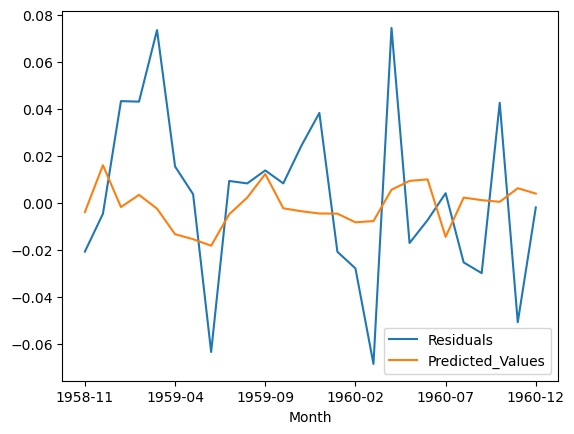

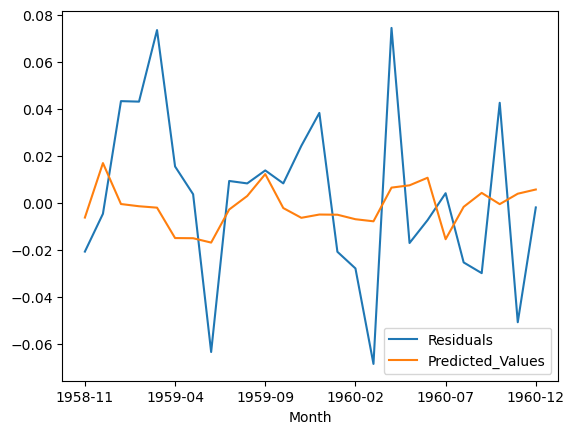

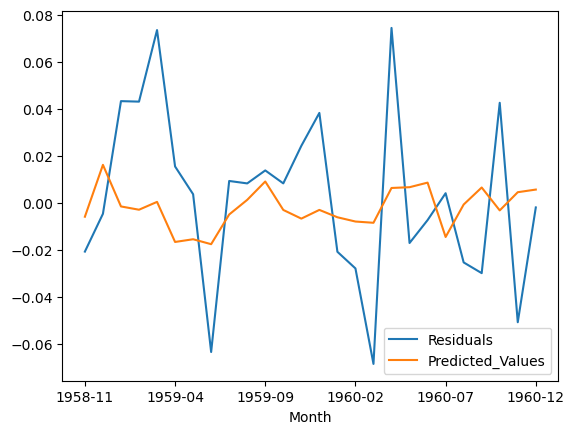

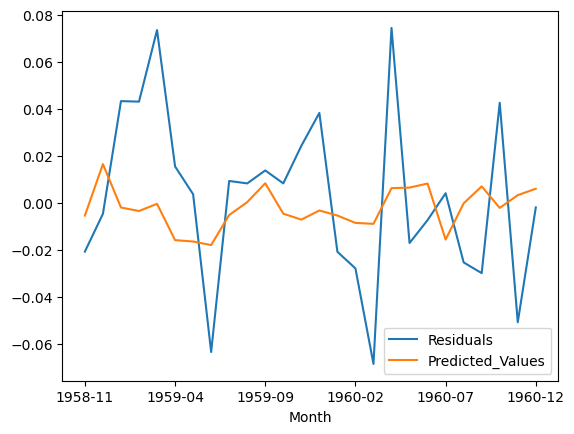

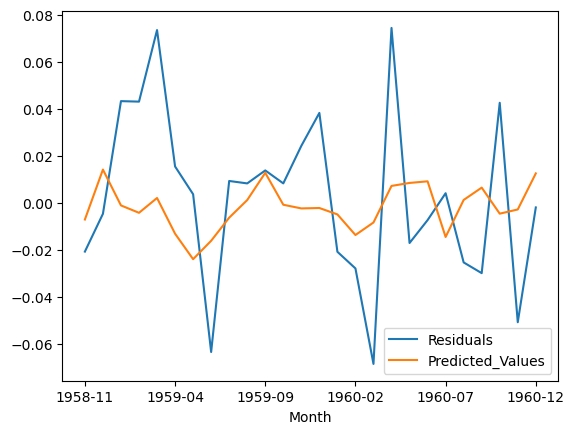

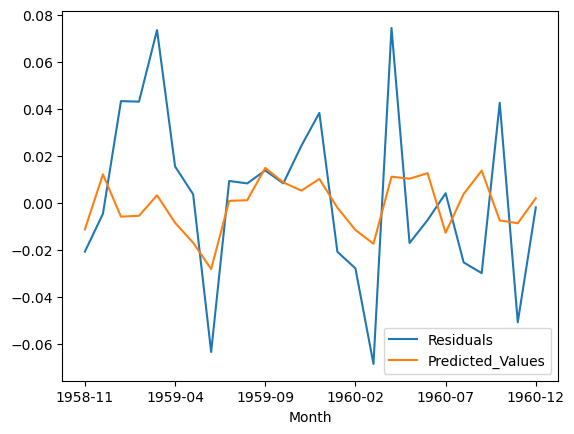

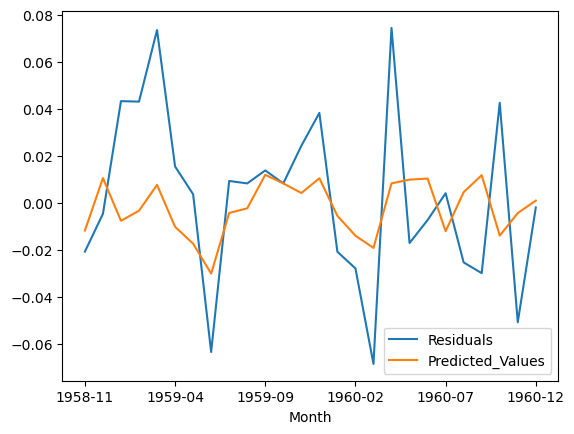

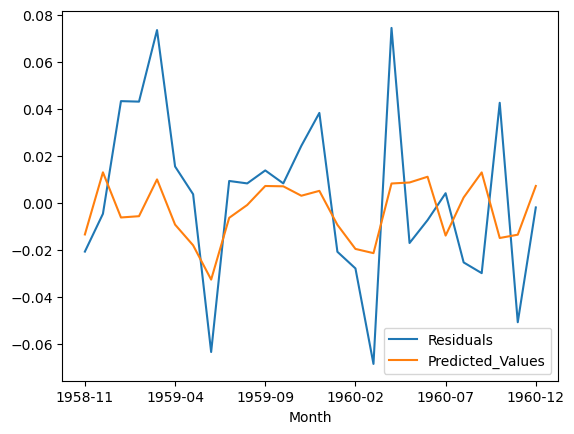

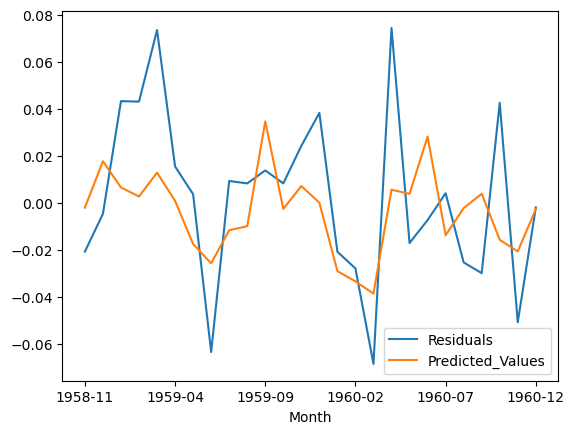

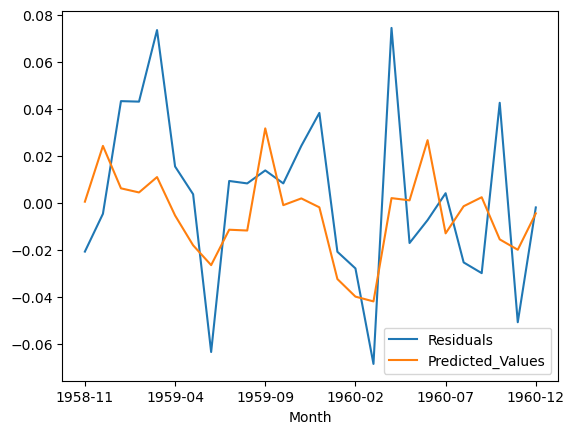

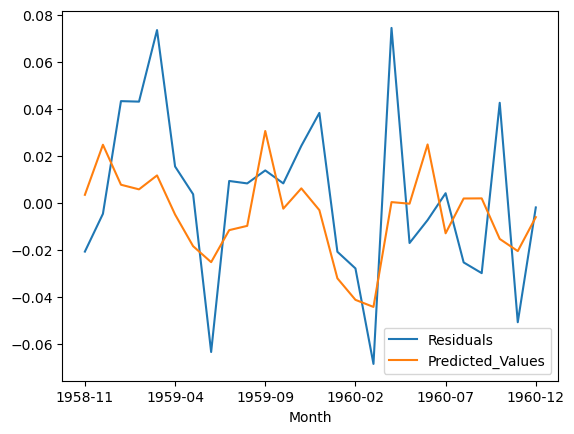

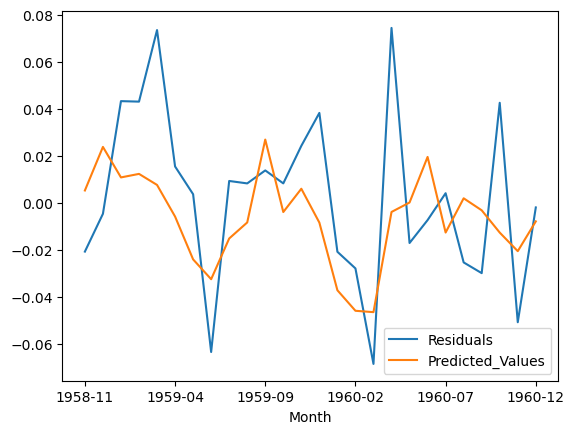

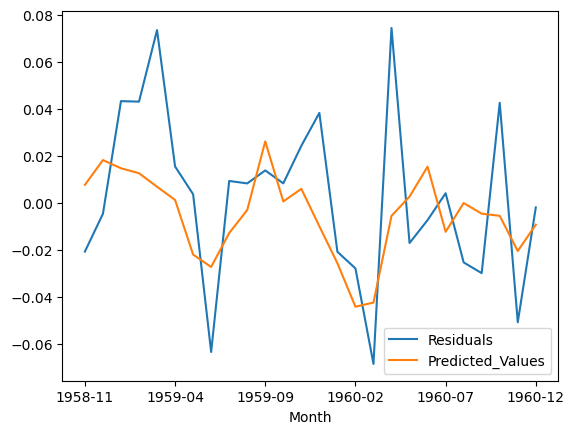

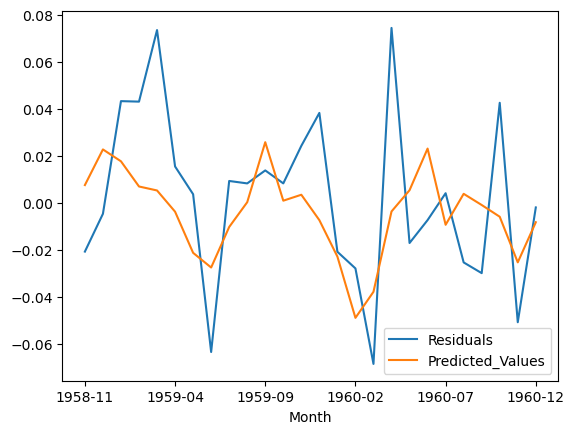

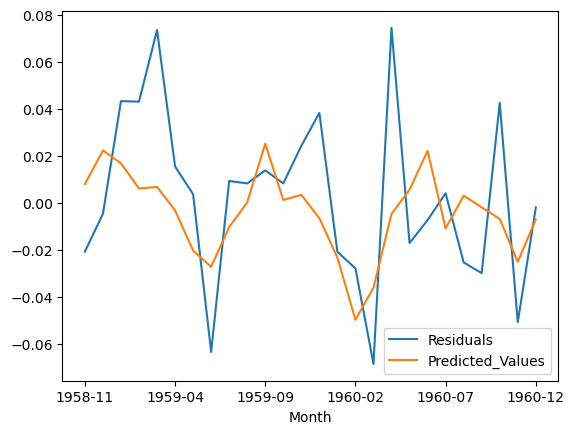

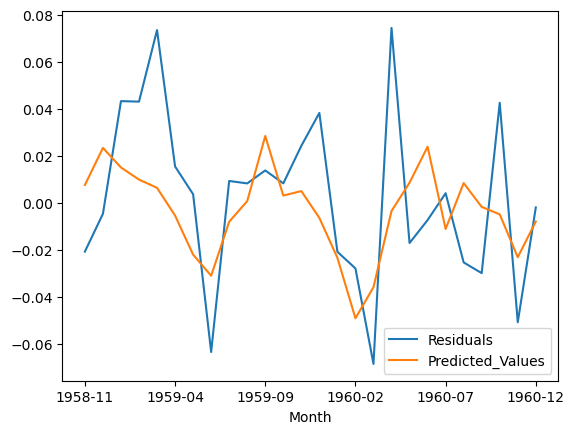

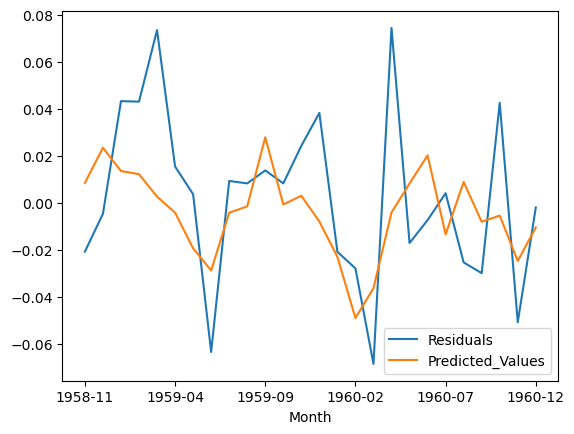

In [31]:


for i in range(1,21):
    
  [res_train,res_test,theta,intercept,RMSE] = MA(i,pd.DataFrame(res.Residuals))
                                                                


The RMSE is : 0.03183724748707899 , Value of q :  12
[[-0.08646583]
 [-0.02054565]
 [-0.15167953]
 [-0.01862362]
 [ 0.04652101]
 [-0.06488491]
 [-0.00841954]
 [ 0.07991   ]
 [ 0.07822852]
 [-0.04660576]
 [-0.10041143]
 [-0.35937205]]
[-0.00214947]


C:\Users\user\AppData\Local\Temp\ipykernel_8756\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


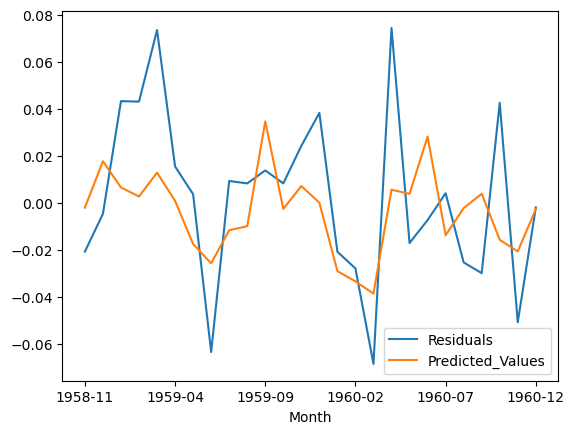

In [32]:
[res_train,res_test,theta,intercept,RMSE] = MA(12,pd.DataFrame(res.Residuals))
print(theta)
print(intercept)
     

In [33]:
res1 = pd.concat([res_train,res_test])

In [34]:
res1

,Residuals,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10,Shifted_values_11,Shifted_values_12,Predicted_Values
Month,,,,,,,,,,,,,,
1951-03,0.046001,-0.003178,0.053948,0.090025,-0.051543,-0.008724,-0.007008,0.025698,0.047126,0.071661,-0.051227,-0.007798,0.015581,-0.008903
1951-04,-0.018201,0.046001,-0.003178,0.053948,0.090025,-0.051543,-0.008724,-0.007008,0.025698,0.047126,0.071661,-0.051227,-0.007798,-0.007347
1951-05,0.086582,-0.018201,0.046001,-0.003178,0.053948,0.090025,-0.051543,-0.008724,-0.007008,0.025698,0.047126,0.071661,-0.051227,0.016030
1951-06,-0.107654,0.086582,-0.018201,0.046001,-0.003178,0.053948,0.090025,-0.051543,-0.008724,-0.007008,0.025698,0.047126,0.071661,-0.052005
1951-07,-0.051199,-0.107654,0.086582,-0.018201,0.046001,-0.003178,0.053948,0.090025,-0.051543,-0.008724,-0.007008,0.025698,0.047126,-0.021113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960-08,-0.025259,0.004156,-0.007271,-0.017009,0.074417,-0.068407,-0.027810,-0.020737,0.038291,0.024292,0.008332,0.013844,0.008325,-0.002179
1960-09,-0.029820,-0.025259,0.004156,-0.007271,-0.017009,0.074417,-0.068407,-0.027810,-0.020737,0.038291,0.024292,0.008332,0.013844,0.003898
1960-10,0.042594,-0.029820,-0.025259,0.004156,-0.007271,-0.017009,0.074417,-0.068407,-0.027810,-0.020737,0.038291,0.024292,0.008332,-0.015654


In [35]:
df2.Predicted_Values += res1.Predicted_Values
     


<Axes: xlabel='Month'>

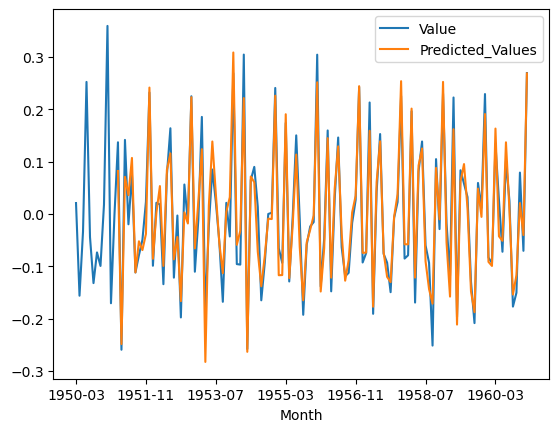

In [36]:
df2[['Value','Predicted_Values']].plot()
     

In [37]:
#PREDICTING THE VALUES

In [38]:
df2.Value += np.log(df).shift(1).Value
df2.Value += np.log(df).diff().shift(12).Value
df2.Predicted_Values += np.log(df).shift(1).Value 
df2.Predicted_Values += np.log(df).diff().shift(12).Value
df2.Value = np.exp(df2.Value)
df2.Predicted_Values = np.exp(df2.Predicted_Values)
     

In [39]:
df2

,Value,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10,Shifted_values_11,Shifted_values_12,Predicted_Values
Month,,,,,,,,,,,,,,
1950-03,143.958838,0.117102,-0.152046,0.261026,-0.001201,-0.048974,-0.084557,-0.091937,-0.017547,0.173506,-0.041032,-0.135107,0.059932,NaN
1950-04,117.896518,0.021128,0.117102,-0.152046,0.261026,-0.001201,-0.048974,-0.084557,-0.091937,-0.017547,0.173506,-0.041032,-0.135107,NaN
1950-05,122.459087,-0.155963,0.021128,0.117102,-0.152046,0.261026,-0.001201,-0.048974,-0.084557,-0.091937,-0.017547,0.173506,-0.041032,NaN
1950-06,179.538843,-0.033476,-0.155963,0.021128,0.117102,-0.152046,0.261026,-0.001201,-0.048974,-0.084557,-0.091937,-0.017547,0.173506,NaN
1950-07,156.350982,0.252594,-0.033476,-0.155963,0.021128,0.117102,-0.152046,0.261026,-0.001201,-0.048974,-0.084557,-0.091937,-0.017547,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960-08,531.700748,0.025386,0.101707,-0.071946,0.026364,0.133542,-0.093578,-0.083044,0.229412,0.011745,0.059509,-0.208297,-0.129422,544.115063
1960-09,431.867633,-0.176733,0.025386,0.101707,-0.071946,0.026364,0.133542,-0.093578,-0.083044,0.229412,0.011745,0.059509,-0.208297,446.677733
1960-10,483.418488,-0.150338,-0.176733,0.025386,0.101707,-0.071946,0.026364,0.133542,-0.093578,-0.083044,0.229412,0.011745,0.059509,456.064914


In [40]:
#PLOTTING THE VALUES AGAINST THE TEST DATA

<Axes: xlabel='Month'>

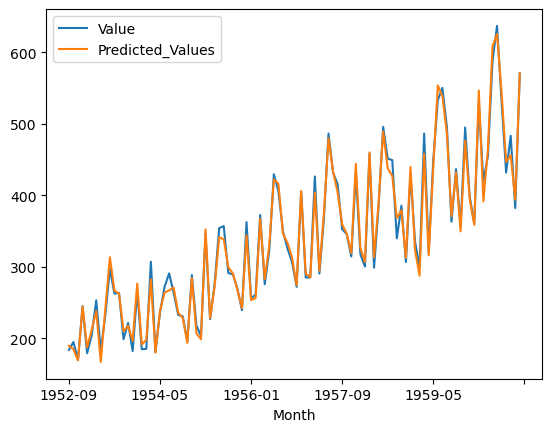

In [41]:
df2.iloc[30:,:][['Value','Predicted_Values']].plot()

In [42]:
vaf=df2.drop(['Shifted_values_1','Shifted_values_2','Shifted_values_3',
          'Shifted_values_4','Shifted_values_5','Shifted_values_6','Shifted_values_7','Shifted_values_8',
          'Shifted_values_9','Shifted_values_10','Shifted_values_11','Shifted_values_12','Predicted_Values'],axis=1)
vaf


,Value
Month,
1950-03,143.958838
1950-04,117.896518
1950-05,122.459087
1950-06,179.538843
1950-07,156.350982
...,...
1960-08,531.700748
1960-09,431.867633
1960-10,483.418488


In [43]:
bf=df2.drop(['Value','Shifted_values_1','Shifted_values_2','Shifted_values_3',
          'Shifted_values_4','Shifted_values_5','Shifted_values_6','Shifted_values_7','Shifted_values_8',
          'Shifted_values_9','Shifted_values_10','Shifted_values_11','Shifted_values_12'],axis=1)
bf

,Predicted_Values
Month,
1950-03,NaN
1950-04,NaN
1950-05,NaN
1950-06,NaN
1950-07,NaN
...,...
1960-08,544.115063
1960-09,446.677733
1960-10,456.064914


In [44]:
ddf=bf[12:]
ddf

,Predicted_Values
Month,
1951-03,182.264095
1951-04,132.949611
1951-05,162.067872
1951-06,212.580533
1951-07,226.094723
...,...
1960-08,544.115063
1960-09,446.677733
1960-10,456.064914


In [45]:
pf1=ddf
pf1

,Predicted_Values
Month,
1951-03,182.264095
1951-04,132.949611
1951-05,162.067872
1951-06,212.580533
1951-07,226.094723
...,...
1960-08,544.115063
1960-09,446.677733
1960-10,456.064914


In [46]:
af=vaf[12:]
af

,Value
Month,
1951-03,192.550794
1951-04,131.514463
1951-05,173.915019
1951-06,201.073767
1951-07,219.393711
...,...
1960-08,531.700748
1960-09,431.867633
1960-10,483.418488


In [47]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(af['Value'],ddf['Predicted_Values']))

print('RMSE:',rmse)

RMSE: 10.835594701310063


In [48]:
from sklearn.metrics import mean_absolute_percentage_error

mape=mean_absolute_percentage_error(af['Value'],ddf['Predicted_Values'])

print('MAPE:',mape)

MAPE: 0.027939506191169593


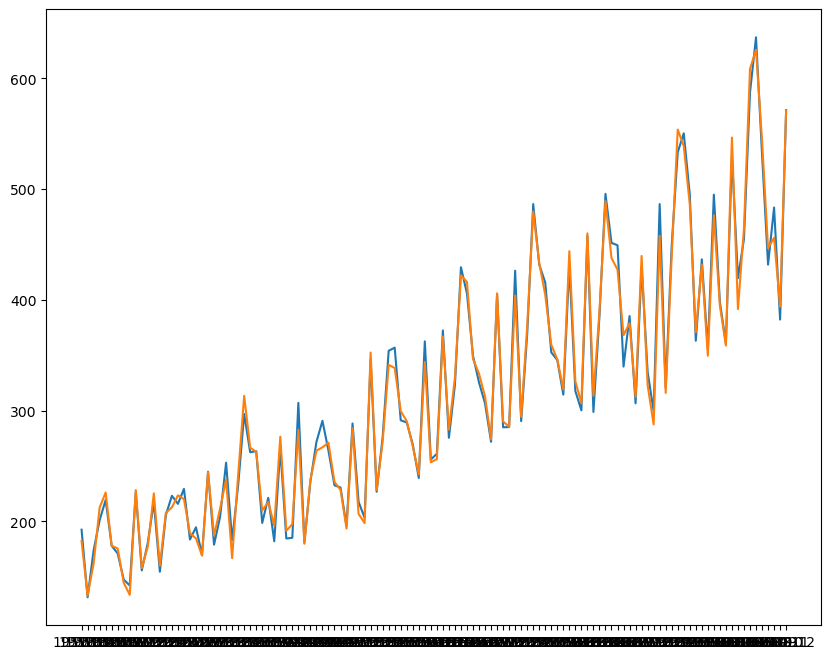

In [49]:
plt.figure(figsize=(10,8))
plt.plot(af)
plt.plot(ddf)

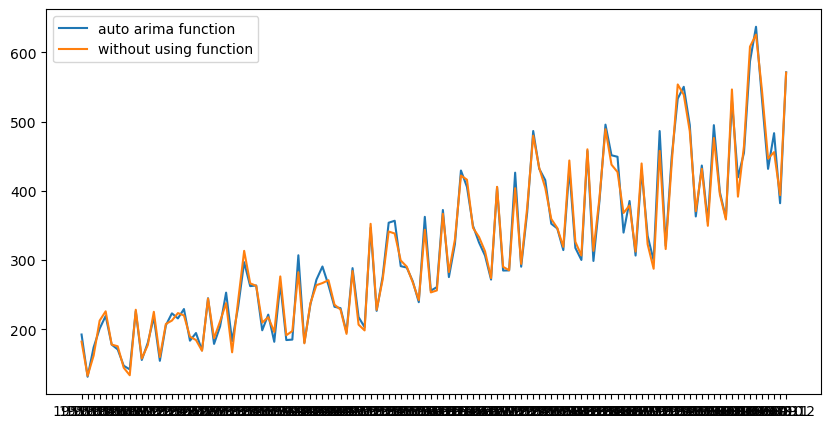

In [59]:
plt.figure(figsize=(10,5))
plt.plot(af,label='auto arima function')
plt.plot(ddf,label='without using function')
plt.legend(loc='upper left')
plt.show()

In [50]:

train_size = (int)(0.8 * df.shape[0])



In [51]:
train = pd.DataFrame(df[0:train_size])
test = pd.DataFrame(df[train_size:df.shape[0]])


In [52]:
test

,Value
Month,
1958-08,505
1958-09,404
1958-10,359
1958-11,310
1958-12,337
1959-01,360
1959-02,342
1959-03,406
1959-04,396


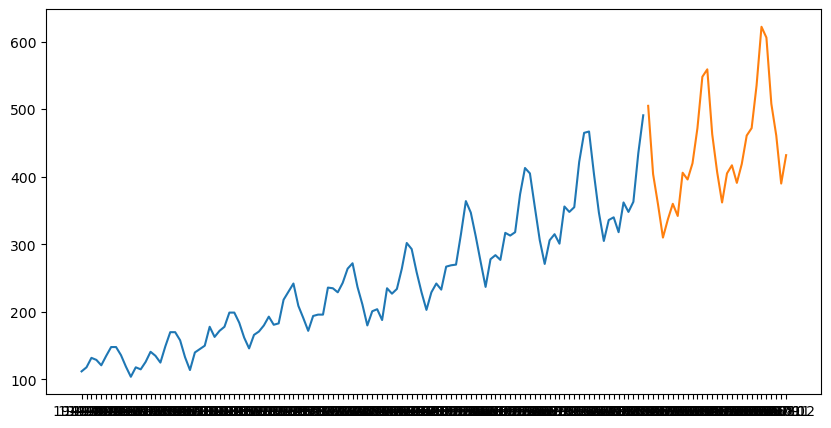

In [53]:
plt.figure(figsize=(10,5))
plt.plot(train)
plt.plot(test)

In [54]:
arima_model=auto_arima(train,start_p=0,d=1,start_q=0,
                      start_P=0,D=1,start_Q=0,
                      max_p=20,max_q=20,max_d=20,
                      max_P=20,max_Q=20,max_D=20,m=12,
                      seasonal=True,error_action='warn',
                      trace=True,supress_warnings=True,
                      stepwise=True,
                      random_state=20,n_fits=10)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=755.750, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=756.380, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=755.499, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=755.982, Time=0.19 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=757.649, Time=0.09 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=756.771, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=756.022, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=756.011, Time=0.03 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=757.976, Time=0.05 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=757.438, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 0.704 seconds


In [55]:
pf=pd.DataFrame(arima_model.predict(n_periods=29),index=test.index)
pf.columns=['predicted_pasengers']
pf

,predicted_pasengers
Month,
1958-08,490.337911
1958-09,427.883043
1958-10,370.771413
1958-11,328.794272
1958-12,359.789591
1959-01,363.790550
1959-02,341.790353
1959-03,385.790394
1959-04,371.790385


In [56]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -375.750
Date:                            Fri, 29 Sep 2023   AIC                            755.499
Time:                                    14:37:24   BIC                            760.749
Sample:                                01-01-1949   HQIC                           757.625
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2048      0.090     -2.271      0.023      -0.382      -0.028
sigma2        92.6974     13.326      6.956      0.000      66.579     118.816
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 2.44
Prob(Q):                              0.87   Prob(JB):                         0.30
Heteroskedasticity (H):               0.96   Skew:                             0.37
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

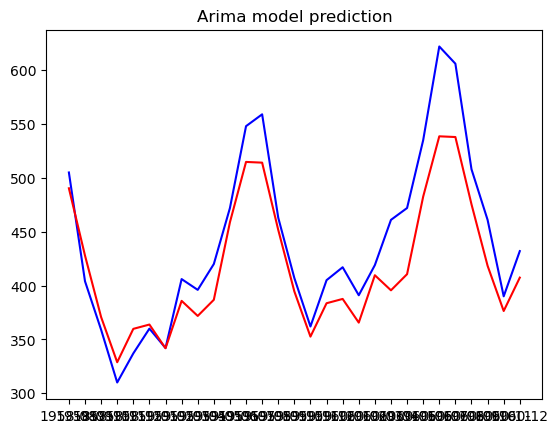

In [57]:
                                                                               
plt.plot(test,color='blue',label="Test")
plt.plot(pf,color='red',label="predicted")
plt.title('Arima model prediction')
plt.show()